In [3]:
%cd drive/My\ Drive/thesis

!ls

/content/drive/My Drive/thesis
'Computation and Language'   glove.6B.300d.txt	 Graphics
 data.csv		     glove.6B.50d.txt	'Information Theory'
 data.gsheet		     glove.6B.zip	 logs


In [4]:
import tensorflow as tf
import pandas as pd
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import os, sys , re , unicodedata
import numpy as np


In [5]:
data = pd.read_csv("data.csv")
data.head()

,id,summary,keywords_freq,keywords_deg,keywords_ratio
0,9507013v1,indexed languages are interesting in computati...,"least class,indexed languages,exactly describe...","least class,indexed languages,exactly describe...","unification grammars,string set,computational ..."
1,0801.1415v1,"a simple review by a linguist, citing many art...","language typology,language dynamics,simple rev...","language typology,language dynamics,simple rev...","simple review,quantitative methods,language ty..."
2,1612.07486v2,most existing models for multilingual natural ...,"treat language,language varieties,language,als...","treat language,language varieties,language,als...","make predictions,learned efficiently,improve i..."
3,1604.08561v1,we introduce a new measure of distance between...,"natural languages,languages classification,lan...","natural languages,languages classification,lan...","word embedding,significant high,result confirm..."
4,0201082v1,we show a representation of quantum computers ...,"create examples,quantum grammars,examples,alge...","create examples,quantum grammars,algebraic app...","quantum grammars,algebraic approach,create exa..."


In [6]:
data.drop_duplicates(subset=['summary'],inplace=True)
data.dropna(axis=0,inplace=True)

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def unicode_to_ascii(s):
  s =  ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')
  s = re.sub(r"[^a-zA-Z?¿<>']+", " ", s) # Removing non - alphanumeric words
  s = re.sub(r"'",'',s)
  s = s.lower() #To lowercase
  return s

def preprocess(w):
    w = w.lower()
    tokens = [w for w in w.split() if not w in stop_words]
    w = " ".join(tokens)
    w = unicode_to_ascii(w) # to remove accents
    w = w.strip().rstrip()
    w = re.sub(r"([?.!,])", r"", w)
    w = re.sub(r'[" "]+', " ", w)
    return w

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
data['processed_text'] = data['summary'].apply(preprocess)

In [9]:
data['class'] = data['keywords_freq'].apply(lambda w : " ".join(w.split(",")))

In [11]:
data.head()

,id,summary,keywords_freq,keywords_deg,keywords_ratio,processed_text,class
0,9507013v1,indexed languages are interesting in computati...,"least class,indexed languages,exactly describe...","least class,indexed languages,exactly describe...","unification grammars,string set,computational ...",indexed languages interesting computational li...,least class indexed languages exactly describe...
1,0801.1415v1,"a simple review by a linguist, citing many art...","language typology,language dynamics,simple rev...","language typology,language dynamics,simple rev...","simple review,quantitative methods,language ty...",simple review linguist citing many articles ph...,language typology language dynamics simple rev...
2,1612.07486v2,most existing models for multilingual natural ...,"treat language,language varieties,language,als...","treat language,language varieties,language,als...","make predictions,learned efficiently,improve i...",existing models multilingual natural language ...,treat language language varieties language als...
3,1604.08561v1,we introduce a new measure of distance between...,"natural languages,languages classification,lan...","natural languages,languages classification,lan...","word embedding,significant high,result confirm...",introduce new measure distance languages based...,natural languages languages classification lan...
4,0201082v1,we show a representation of quantum computers ...,"create examples,quantum grammars,examples,alge...","create examples,quantum grammars,algebraic app...","quantum grammars,algebraic approach,create exa...",show representation quantum computers defines ...,create examples quantum grammars examples alge...


In [10]:
data['processed_class'] = data['class'].apply(lambda w : '<BOS> '+ w + ' <EOS>')


In [ ]:
data.head()

,id,summary,keywords_freq,keywords_deg,keywords_ratio,processed_text,class,processed_class
0,9507013v1,indexed languages are interesting in computati...,"least class,indexed languages,exactly describe...","least class,indexed languages,exactly describe...","unification grammars,string set,computational ...",indexed languages interesting computational li...,least class indexed languages exactly describe...,<BOS> least class indexed languages exactly de...
1,0801.1415v1,"a simple review by a linguist, citing many art...","language typology,language dynamics,simple rev...","language typology,language dynamics,simple rev...","simple review,quantitative methods,language ty...",simple review linguist citing many articles ph...,language typology language dynamics simple rev...,<BOS> language typology language dynamics simp...
2,1612.07486v2,most existing models for multilingual natural ...,"treat language,language varieties,language,als...","treat language,language varieties,language,als...","make predictions,learned efficiently,improve i...",existing models multilingual natural language ...,treat language language varieties language als...,<BOS> treat language language varieties langua...
3,1604.08561v1,we introduce a new measure of distance between...,"natural languages,languages classification,lan...","natural languages,languages classification,lan...","word embedding,significant high,result confirm...",introduce new measure distance languages based...,natural languages languages classification lan...,<BOS> natural languages languages classificati...
4,0201082v1,we show a representation of quantum computers ...,"create examples,quantum grammars,examples,alge...","create examples,quantum grammars,algebraic app...","quantum grammars,algebraic approach,create exa...",show representation quantum computers defines ...,create examples quantum grammars examples alge...,<BOS> create examples quantum grammars example...


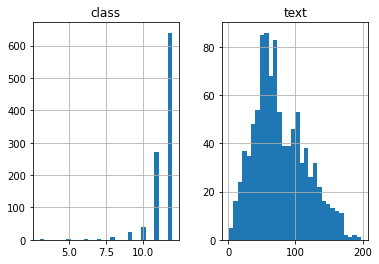

In [12]:

import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['processed_text']:
      text_word_count.append(len(i.split()))

for i in data['processed_class']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'class':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [11]:
max_len_text= 200 
max_len_summary = 6
from sklearn.model_selection import train_test_split
X_train ,X_test, Y_train, Y_test = train_test_split(list(data['processed_text']),list(data['processed_class']),test_size=0.2,random_state=42,shuffle=True) 

In [13]:
input_tokenizer = tf.keras.preprocessing.text.Tokenizer()
input_tokenizer.fit_on_texts(X_train)
X_train_tokens = input_tokenizer.texts_to_sequences(X_train)

X_test_tokens = input_tokenizer.texts_to_sequences(X_test)

X_train_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokens , maxlen= max_len_text , padding='post')
X_test_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokens , maxlen= max_len_text , padding='post')
Source_vocabulary = input_tokenizer.word_index

X_vocab_size   =  len(input_tokenizer.word_index) +1

In [14]:
output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(Y_train)

Y_train_tokens    =   output_tokenizer.texts_to_sequences(Y_train) 
Y_test_tokens   =   output_tokenizer.texts_to_sequences(Y_test) 

Y_train_tokens    =   tf.keras.preprocessing.sequence.pad_sequences(Y_train_tokens, maxlen=max_len_summary, padding='post')
Y_test_tokens   =   tf.keras.preprocessing.sequence.pad_sequences(Y_test_tokens, maxlen=max_len_summary, padding='post')

Y_vocab_size  =   len(output_tokenizer.word_index) +1

In [15]:
from tensorflow.python.keras import backend as K

# From TensorFlow Implementation https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function &

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(BahdanauAttention, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [27]:
# !wget nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

--2020-08-02 20:34:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-02 20:34:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-02 20:34:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [16]:
# !unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
embeddings_dict = {}
with open("glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [18]:
#Example from keras.io
num_words = min(10000, len(Source_vocabulary) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, index in Source_vocabulary.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
def get_model(params):
    latent_dim = 300 

    # Encoder 
    encoder_inputs = Input(shape=(max_len_text,)) 
    enc_emb = Embedding(X_vocab_size, latent_dim,trainable=True, weights=[embedding_matrix])(encoder_inputs) 

    #LSTM 1 
    encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

    #LSTM 2 
    encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

    #LSTM 3 
    encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

    # Set up the decoder. 
    decoder_inputs = Input(shape=(None,)) 
    dec_emb_layer = Embedding(Y_vocab_size, latent_dim,trainable=True) 
    dec_emb = dec_emb_layer(decoder_inputs) 

    #LSTM using encoder_states as initial state
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
    decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

    #Attention Layer
    attn_layer = BahdanauAttention(name="attention") 
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

    # Concat attention output and decoder LSTM output 
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    #Dense layer
    decoder_dense = TimeDistributed(Dense(Y_vocab_size, activation='softmax')) 
    decoder_outputs = decoder_dense(decoder_concat_input) 
    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=params[0])
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy') 
    model.summary()

    # encoder inference
    
    encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

    # decoder inference
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

    # Get the embeddings of the decoder sequence
    dec_emb2= dec_emb_layer(decoder_inputs)

    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

    #attention inference
    attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_outputs2 = decoder_dense(decoder_inf_concat)

    # Final decoder model
    decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
    return model , encoder_model , decoder_model

In [34]:
params = [
    {
        'learning_rate': 0.001,
        'min': 0.0001,
        'max': 0.1,
        'low': 0.000001,
        'high': 1,
        'type': float,
    },
    {
        'input_dim': 30,
        'min': 8,
        'max': 16,
        'low': 4,
        'high': 16,
        'type': int,
        'step' : 1
    }
]
model , encoder_model , decoder_model = get_model([0.0001 , 16])

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 200, 300)     2283900     input_12[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 200, 300), ( 721200      embedding_8[0][0]                
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [39]:
history= model.fit([X_train_tokens,Y_train_tokens[:,:-1]], Y_train_tokens.reshape(Y_train_tokens.shape[0],Y_train_tokens.shape[1], 1)[:,1:] ,epochs=20,batch_size=64, validation_split=0.2)


Epoch 1/20
10/10 [==============================] - 1s 131ms/step - loss: 6.1549 - val_loss: 6.3485
Epoch 2/20
10/10 [==============================] - 1s 129ms/step - loss: 5.9998 - val_loss: 6.3250
Epoch 3/20
10/10 [==============================] - 1s 129ms/step - loss: 5.8906 - val_loss: 6.3314
Epoch 4/20
10/10 [==============================] - 1s 129ms/step - loss: 5.8102 - val_loss: 6.3585
Epoch 5/20
10/10 [==============================] - 1s 128ms/step - loss: 5.7471 - val_loss: 6.3790
Epoch 6/20
10/10 [==============================] - 1s 128ms/step - loss: 5.6832 - val_loss: 6.3047
Epoch 7/20
10/10 [==============================] - 1s 130ms/step - loss: 5.6304 - val_loss: 6.3501
Epoch 8/20
10/10 [==============================] - 1s 129ms/step - loss: 5.5913 - val_loss: 6.3731
Epoch 9/20
10/10 [==============================] - 1s 128ms/step - loss: 5.5556 - val_loss: 6.3279
Epoch 10/20
10/10 [==============================] - 1s 129ms/step - loss: 5.5371 - val_loss: 6.4574

In [97]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

NameError: ignored

In [37]:

reverse_target_word_index = output_tokenizer .index_word 
reverse_source_word_index = input_tokenizer .index_word 
target_word_index = output_tokenizer.word_index

In [27]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

NameError: ignored

In [40]:
import numpy as np 
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['bos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [41]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['bos']) and i!=target_word_index['eos']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [42]:
#reverse_source_word_index = {y:x for x,y in reverse_source_word_index.items()}
def eval_summarizer(X):
    resp = list()
    for x in X:
        resp.append(decode_sequence(x.reshape(1,max_len_text) ))
    return resp

In [43]:
for i in range(5):
  print("Review:",seq2text(X_test_tokens[i]))
  print("Original summary:",seq2summary(Y_test_tokens[i]))
  print("Predicted summary:",decode_sequence(X_test_tokens[i].reshape(1,max_len_text)))
  print("\n")

Review: graphical modelling long history statistics tool analysis multivariate data starting path analysis gibbs applications statistical physics beginning last century modern form lauritzen pearl s since found applications fields diverse bioinformatics satisfaction surveys weather genetics systems biology unique among fields dimension data sets study often contain several hundreds variables tens hundreds observations raises problems computational complexity statistical significance resulting networks known dimensionality furthermore data difficult model correctly due limited understanding underlying mechanisms following illustrate challenges affect practical graphical modelling possible solutions 
Original summary: sets statistical statistical physics analysis 
Predicted summary:  graphical graphical graphical


Review: using functional derivatives respect free correlation function derive closed set equations phi theory conversion graphical recursion relations allows us systematically

In [84]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow import keras

random.seed(42)
np.random.seed(42)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
writer = tf.summary.create_file_writer(logdir)



class Genetic():
    def __init__(self, X_train, Y_train, X_test, Y_test, params, model_fn , eval_fn=None):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.hyper_params = params
        self.tuneable_params = list()
        self.score_fn = None
        self.model_fn = model_fn
        self.eval_fn = eval_fn

    def set_population(self, p):
        self.population = p

    def init_population(self, parents=8):
        for i, e in enumerate(self.hyper_params):
            self.tuneable_params.append(
                np.empty([parents, 1], dtype=e['type']))
            for j in range(parents):
                if 'step' in e:
                    self.tuneable_params[i][j] = random.randrange(
                        e['min'], e['max'], step=e['step'])
                else:
                    self.tuneable_params[i][j] = random.uniform(
                        e['min'], e['max'])
        self.population = np.asarray(self.tuneable_params)
        self.population = np.concatenate(self.population, axis=1)
        return self.population

    def set_score_fn(self, score_fn):
        self.score_fn = score_fn

    def score(self, y_pred):
        if self.score_fn is None:
            self.score_fn = f1_score
        return self.score_fn(y_pred, self.Y_test)

    # train the data annd find fitness score

    
    def train__population(self):
        fScore = []
        for i in range(self.population.shape[0]):
            print('param', self.population[i][0])
            model , _ ,_ = self.model_fn(self.population[i])
            
            # model.fit([X_train_tokens,Y_train_tokens[:,:-1]], Y_train_tokens.reshape(Y_train_tokens.shape[0],Y_train_tokens.shape[1], 1)[:,1:] ,epochs=200,batch_size=64, validation_split=0.2)
            model.fit([self.X_train,self.Y_train[:,:-1]], \
                            self.Y_train.reshape(self.Y_train.shape[0],self.Y_train.shape[1], 1)[:,1:] , 
                            epochs=5,batch_size=64, validation_split=0.2)
            if not self.eval_fn:
                preds = model.predict(self.X_test)
                preds = preds > 0.5
            else:
                preds = self.eval_fn(self.X_test)
            fScore.append(self.score(preds))

        self.curr_score = np.asarray(fScore)
        return fScore

    # Survial of fittest

    def form_parents(self, population, fitness_scores, n_parents):
        selectedParents = np.empty((n_parents, population.shape[1]))

        for i in range(n_parents):
            max_score = np.where(fitness_scores == np.max(fitness_scores))
            max_score = max_score[0][0]
            selectedParents[i, :] = population[max_score, :]
            fitness_scores[max_score] = -1
        return selectedParents


    
    def crossover_uniform(self, parents, childrenSize):

        crossoverPointIndex = np.arange(0, np.uint8(
            childrenSize[1]), 1, dtype=np.uint8)  # get all the index
        crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(
            childrenSize[1]/2))  # select half  of the indexes randomly
        crossoverPointIndex2 = np.array(list(
            set(crossoverPointIndex) - set(crossoverPointIndex1)))  # select leftover indexes

        children = np.empty(childrenSize)

        for i in range(childrenSize[0]):

            # find parent 1 index
            parent1_index = i % parents.shape[0]
            # find parent 2 index
            parent2_index = (i+1) % parents.shape[0]
            # insert parameters based on random selected indexes in parent 1
            children[i, crossoverPointIndex1] = parents[parent1_index,
                                                        crossoverPointIndex1]
            # insert parameters based on random selected indexes in parent 1
            children[i, crossoverPointIndex2] = parents[parent2_index,
                                                        crossoverPointIndex2]
        return children

    def mutation(self, crossover, n_params):
        # Define minimum and maximum values allowed for each parameter

        m_value = np.zeros((n_params, 2))
        for i, e in enumerate(self.hyper_params):
            m_value[i, :] = [e['min'], e['max']]

        mutationValue = 0
        rand_mutate = np.random.randint(0, len(self.hyper_params), 1)[0]
        mutationValue = round(np.random.uniform(
            self.hyper_params[rand_mutate]['low'], self.hyper_params[rand_mutate]['high']), 2)

        for i in range(crossover.shape[0]):
            crossover[i, rand_mutate] = crossover[i,
                                                  rand_mutate] + mutationValue
            if(crossover[i, rand_mutate] > m_value[rand_mutate, 1]):
                crossover[i, rand_mutate] = m_value[rand_mutate, 1]
            if(crossover[i, rand_mutate] < m_value[rand_mutate, 0]):
                crossover[i, rand_mutate] = m_value[rand_mutate, 0]
        return crossover


    


    def train(self, n_parents=3, min_parent_mating=2, n_generation=1):
        assert min_parent_mating >= 2
        assert n_generation > 0
        assert n_parents >= 3
        n_params = len(self.hyper_params)
        population_size = (n_parents, n_params)

        population = self.init_population(n_parents)

        # define an array to store the fitness  hitory
        fitnessHistory = np.empty([n_generation + 1, n_parents])

        populationHistory = np.empty(
            [(n_generation+1)*n_parents, n_params])

        populationHistory[0:n_parents, :] = population

        for generation in range(n_generation):
            self.curr_gen = generation
            print("This is number %s generation" % (generation))

            # train the dataset and obtain fitness
            fitnessValue = self.train__population()
            fitnessHistory[generation, :] = fitnessValue

            # best score in the current iteration
            print('Best max in the this iteration = {}'.format(
                np.max(fitnessHistory[generation, :])))
            
            with writer.as_default():
                tf.summary.scalar("generation {0}".format(generation), self.curr_score.mean(), step=generation)

            # survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
            parents = self.form_parents(
                population=population, fitness_scores=fitnessValue, n_parents=min_parent_mating)

            # mate these parents to create children having parameters from these parents (we are using uniform crossover)
            children = self.crossover_uniform(parents=parents, childrenSize=(
                population_size[0] - parents.shape[0], n_params))

            children_mutated = self.mutation(children, n_params)

            population[0:parents.shape[0], :] = parents  # fittest parents
            population[parents.shape[0]:, :] = children_mutated  # children

            populationHistory[(generation+1)*n_parents: (generation+1)*n_parents + n_parents, :] = population
            tf.keras.backend.clear_session()


        self.set_population(population)
        fitness = self.train__population()
        fitnessHistory[generation+1, :] = fitness

        # index of the best solution
        best = np.where(fitness == np.max(fitness))[0][0]

        # Best fitness
        print("Best fitness is =", population[best])
        # self.plot_parameters(n_generation, n_parents, fitnessHistory, "fitness (F1-score)")
        return population[best]




In [85]:
from difflib import SequenceMatcher

def score(A, B):
    _score = list()
    for i, a in enumerate(A):
        _score.append(SequenceMatcher(None, a, B[i]).ratio())
    return  np.asarray(_score).mean()



In [63]:
print(score([["a"]] , [["a"]]))
f1_score([["a"]], [["a"]])

1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1305: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.0

In [86]:
g = Genetic(X_train_tokens, Y_train_tokens, X_test_tokens, Y_test, params, get_model , eval_summarizer)

In [80]:
score_fn = tf.keras.losses.sparse_categorical_crossentropy

In [87]:
g.set_score_fn(score)

In [88]:

best = g.train(3,2,1)
print(best)

This is number 0 generation
param 0.06397873716594259
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 300)     2283900     input_16[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 200, 300), ( 721200      embedding_6[0][0]                
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None)]       0                                            
______________________________________